<a href="https://colab.research.google.com/github/ArmandoLp/ImagenesMedicas/blob/main/Copy_of_Clasificador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import recall_score
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import TensorBoard, EarlyStopping
from keras.optimizers import Adam
# import matplotlib.pyplot as plt
import cv2
import numpy as np

Using TensorFlow backend.


In [ ]:
path_Covid = '/content/drive/My Drive/Clasificacion/COVID/'
path_NoCovid = '/content/drive/My Drive/Clasificacion/NonCOVID/'

covid_files = next(os.walk(path_Covid))[2]
noCovid_files = next(os.walk(path_NoCovid))[2]

covid_images = []
noCovid_images = []


In [ ]:
def clas():
    mode_basel = VGG16(weights='imagenet', include_top=False)
    exit_vgg = mode_basel.output
    exit_vgg = GlobalAveragePooling2D()(exit_vgg)
    exit_vgg = Dense(1024, activation='relu')(exit_vgg)
    prediction = Dense(2, activation='softmax')(exit_vgg)
    model = Model(input=mode_basel.input, outputs=prediction)

    for layer in mode_basel.layers:
        layer.trainable = False

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=Adam(lr=0.0001),
                  metrics=['acc'])
    return model

In [ ]:
def readImage(img_filename, img_path):
    image = cv2.imread(img_path + img_filename, 0)
    image = cv2.resize(image, (224, 224))
    # Normalizing image
    high = 255
    low = 0
    cmin = image.min()
    cmax = image.max()
    cscale = cmax - cmin
    scale = float(high - low) / cscale
    new_array = (image - cmin) * scale + low
    image = (new_array.clip(low, high) + 0.5).astype(np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    img_data = image.reshape(224, 224, 3)
    return img_data

In [ ]:
if __name__ == '__main__':
    for file in covid_files:
        covid_images.append(readImage(file, path_Covid))
    print('Numero de ejemplos con Covid: '+str(len(covid_images)))
    for file in noCovid_files:
        noCovid_images.append(readImage(file, path_NoCovid))
    print('Numero de ejemplos con No Covid: '+str(len(noCovid_images)))

    covid_images = np.array(covid_images)
    noCovid_images = np.array(noCovid_images)
    data = np.concatenate((covid_images, noCovid_images), axis=0)
    data_images = data
    ciertos = np.full(len(covid_images), 1)
    falsos = np.full(len(noCovid_images), 0)
    etiquetas = np.concatenate((ciertos, falsos), axis=0)

    print(len(data_images))
    print(len(etiquetas))
    #print(data_images.shape())

    X_train, X_test, y_train, y_test = train_test_split(data_images, etiquetas, test_size=0.33, random_state=42)



Numero de ejemplos con Covid: 347
Numero de ejemplos con No Covid: 397
744
744


In [ ]:
    model = clas()
    tensorboard = TensorBoard(log_dir="/content/drive/My Drive/Entrenamientos_imagenes/model_c")
    stop_callback = EarlyStopping(monitor='val_loss',
                                  min_delta=.0001, patience=100, mode='auto')
    model.fit(X_train, y_train, epochs=10000, batch_size=64*4,
              validation_split=0.1, callbacks=[tensorboard, stop_callback])
    model.save('/content/drive/My Drive/Entrenamientos_imagenes/model.h5')

58892288/58889256 [==============================] - 1s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  import sys


Train on 448 samples, validate on 50 samples
Epoch 1/10000
448/448 [==============================] - 14s 32ms/step - loss: 3.5513 - acc: 0.5536 - val_loss: 1.2881 - val_acc: 0.5800
Epoch 2/10000
448/448 [==============================] - 1s 3ms/step - loss: 1.8057 - acc: 0.5246 - val_loss: 1.7715 - val_acc: 0.5400
Epoch 3/10000
448/448 [==============================] - 1s 3ms/step - loss: 2.4104 - acc: 0.4397 - val_loss: 1.4784 - val_acc: 0.5800
Epoch 4/10000
448/448 [==============================] - 1s 3ms/step - loss: 1.8183 - acc: 0.4821 - val_loss: 0.9070 - val_acc: 0.6600
Epoch 5/10000
448/448 [==============================] - 1s 3ms/step - loss: 1.3506 - acc: 0.5781 - val_loss: 1.3216 - val_acc: 0.5600
Epoch 6/10000
448/448 [==============================] - 1s 3ms/step - loss: 1.5120 - acc: 0.5915 - val_loss: 1.3403 - val_acc: 0.5800
Epoch 7/10000
448/448 [==============================] - 1s 3ms/step - loss: 1.3603 - acc: 0.6272 - val_loss: 0.9033 - val_acc: 0.6600
Epoch 8/

In [ ]:
! pip install scikit-plot

Accuracy: 0.837398
Precision: 0.830645
Recall: 0.844262


<Figure size 216014x115229 with 0 Axes>

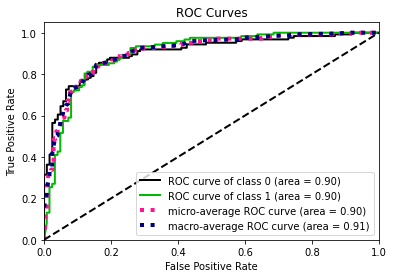

In [ ]:
from keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
import scikitplot as skplt

model = load_model('/content/drive/My Drive/Entrenamientos_imagenes/model.h5')

pred = model.predict(X_test)

prediccion = []
for xs in range(len(pred)):
  v = pred[xs]
  if v[0]> v[1]:
    prediccion.append(0)
  else:
    prediccion.append(1)


accuracy = accuracy_score(y_test, prediccion)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, prediccion)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, prediccion)
print('Recall: %f' % recall)

plt.figure(figsize=(3000.2, 1600.4))
y_true = y_test #aquí pon tu vector original
y_probas = pred #aqui pon las probabilidades del modelo
skplt.metrics.plot_roc(y_true, y_probas)
plt.show()

In [ ]:
+022

# Grafica de tensorboard para el entrenamiento
![tensorboard](https://i.ibb.co/RSZ93Q8/Captura-de-pantalla-de-2020-06-10-14-14-10.png)


 covid_images = np.array(covid_images)
    noCovid_images = np.array(noCovid_images)
    data = np.concatenate((covid_images, noCovid_images), axis=0)
    data_images = data
    ciertos = np.full(len(covid_images), 1)
    falsos = np.full(len(noCovid_images), 0)
    etiquetas = np.concatenate((ciertos, falsos), axis=0)

    print(len(data_images))
    print(len(etiquetas))
    #print(data_images.shape())

    X_train, X_test, y_train, y_test = train_test_split(data_images, etiquetas, test_size=0.33, random_state=42)


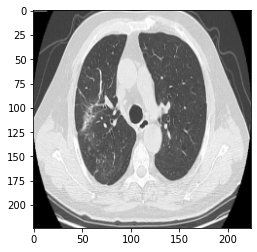

In [ ]:
X_train[0].shape
import matplotlib.pyplot as plt
ax=plt
ax.imshow(X_train[3])

In [ ]:
!pip3 install pydicom

     |████████████████████████████████| 35.5MB 88kB/s 


In [ ]:
import os
import pydicom
from matplotlib import pyplot as plt
import cv2
import numpy as np

def readDICOMImage(img_filename,img_path):
    
    dicom_img = pydicom.dcmread(img_path + img_filename)
    
    return dicom_img

In [ ]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, image_size=128):
        self.ids = ids
        self.path = path
        self.image_size = image_size
        
    #load an image and its mask    
    def __load__(self, id_name):
        
        ## Path
        image_path = os.path.join(self.path,id_name)
        mask_path = os.path.join(self.path,"Mask/",id_name)
        
        ## Reading Image
        image = cv2.imread(image_path, 0)
        
        ## Reading Mask
        mask = cv2.imread(mask_path, 0)
            
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask

In [ ]:
#Flatten all train images
flat_train_images = []

for image in X_train:
    
    flat_image = np.reshape(image, [-1,1])
    flat_train_images.append(flat_image)
    
flat_train_data = np.concatenate((flat_train_images))
print("Train data shape" + str(flat_train_data.shape))

np.random.shuffle(flat_train_data)

Train data shape(74962944, 1)


In [ ]:
#train Kmeans
from sklearn.cluster import KMeans 

import time as time

st = time.time()
Kmeans = KMeans(n_clusters=4)
Kmeans.fit(flat_train_data)
elapsed_time = time.time() - st

print("Elapsed time: %.2fs" % elapsed_time)

Elapsed time: 994.17s


In [ ]:
import pickle
filename = 'kmeans-4cluster.sav'
pickle.dump(Kmeans, open(filename, 'wb'))

In [ ]:
ls

drive/  kmeans-4cluster.sav  sample_data/


In [ ]:
!ls drive/'My Drive'/'Colab Notebooks'/

'Copy of Clasificador.ipynb'   LDA-ProyectoFinal.ipynb	 total_t.csv   Untitled


In [ ]:
!mv kmeans-4cluster.sav drive/'My Drive'/'Colab Notebooks'/


mv: cannot stat 'kmeans-4cluster.sav': No such file or directory


In [ ]:
labels = Kmeans.labels_
centers = np.uint8(Kmeans.cluster_centers_)
print(centers)

[[ 27]
 [238]
 [185]
 [ 87]]


In [ ]:
def getElementsInCluster(labels):
    
    n_clusters = 5
    n_elements_cluster = []
    
    for i in range(n_clusters):
        cluster_idx = np.where(labels==i)[0]
        n_elements_cluster.append(len(cluster_idx))
    
    return n_elements_cluster

n_elements_cluster = getElementsInCluster(labels)
print(n_elements_cluster)

[17421222, 26059902, 14841276, 16640544, 0]


Number of pixels in clusters[54546, 46377, 29454, 20151, 0]


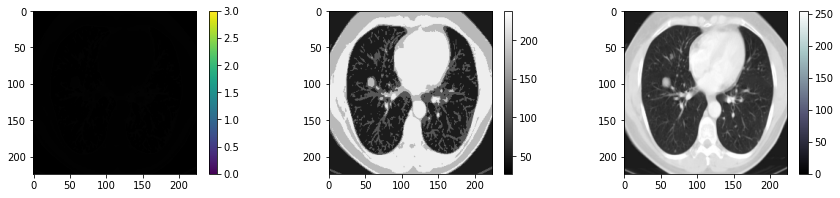

In [ ]:
#Flatten image and use Kmeans to predict cluster
import matplotlib.pyplot as plt

def predictImage(image):
    
    flat_image = np.reshape(image, [-1,1])
    labels = Kmeans.predict(flat_image)
    
    n_elements_cluster = getElementsInCluster(labels)
    print("Number of pixels in clusters" + str(n_elements_cluster))
    
    cluster_image = np.reshape(labels,(224,224,3))
    
    res = centers[labels.flatten()]
    center_image = res.reshape((224,224,3))
    
    return cluster_image, center_image

#Display cluster images,
#color of the cluster center of each pixel
#brain image for comparison
def displayClusterandWindowImage(image,center_image,channel_image):
    
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 3), ncols=3)

    im1 = ax1.imshow(image)
    fig.colorbar(im1, ax=ax1)
    im2 = ax2.imshow(center_image,cmap="gray")
    fig.colorbar(im2, ax=ax2)
    im3 = ax3.imshow(channel_image,cmap="bone")
    fig.colorbar(im3, ax=ax3)
    
    plt.show()
    
cluster_image,center_image = predictImage(X_test[22],)
displayClusterandWindowImage(cluster_image,center_image,X_test[22])

In [ ]:
ct=X_test[3]
cluster_image,center_image = predictImage(ct,)
displayClusterandWindowImage(cluster_image,center_image,ct)
ax=plt
ax.imshow(ct)

NameError: ignored

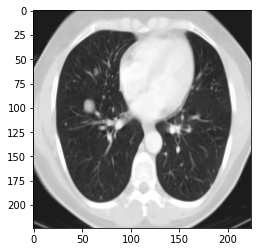

In [ ]:
import matplotlib.pyplot as plt
ax=plt
ax.imshow(X_test[22])